In [1]:
from sklearn.datasets import make_circles

n_samples = 1000           
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [2]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [3]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

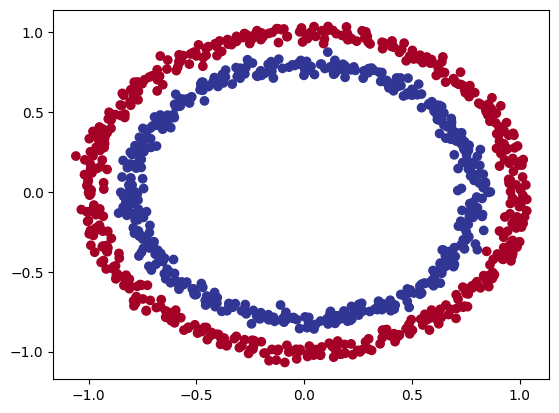

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y, # the colors of the markers will be determined by the values in y.
            cmap = plt.cm.RdYlBu)

In [6]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [8]:
import torch
from torch import nn
device = "mps" if torch.backends.mps.is_available else "cpu"
device

'mps'

In [9]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 100)
        self.layer_2 = nn.Linear(in_features = 100, out_features = 100)
        self.layer_3 = nn.Linear(in_features = 100, out_features = 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [10]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)

In [11]:
# or use nn.sequential 
'''model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)'''                                                                                                        

'model_0 = nn.Sequential(\n    nn.Linear(in_features = 2, out_features = 5),\n    nn.Linear(in_features = 5, out_features = 1)\n).to(device)'

In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [14]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.1604],
        [0.1822],
        [0.2483],
        [0.1690],
        [0.2758]], device='mps:0', grad_fn=<SliceBackward0>)

In [15]:
y_pred_probs = torch.sigmoid(y_logits)
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0', grad_fn=<RoundBackward0>)

In [16]:
torch.manual_seed(42)
from tqdm import tqdm
# Set the number of epochs
epochs = 10000

# Put data to target device  
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training
for epoch in tqdm(range(epochs)):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Testing 
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Accuracy: {acc} | Test loss: {test_loss}, test acc: {test_acc}")
        
    

  0%|▏                                      | 48/10000 [00:00<00:36, 271.01it/s]

Epoch: 0 | Loss: 0.7024075984954834, Accuracy: 50.0 | Test loss: 0.6976513266563416, test acc: 50.0


 10%|███▊                                 | 1043/10000 [00:03<00:35, 253.92it/s]

Epoch: 1000 | Loss: 0.024680985137820244, Accuracy: 100.0 | Test loss: 0.04449819028377533, test acc: 100.0


 20%|███████▌                             | 2037/10000 [00:07<00:35, 224.43it/s]

Epoch: 2000 | Loss: 0.007149916607886553, Accuracy: 100.0 | Test loss: 0.018196970224380493, test acc: 100.0


 30%|███████████▎                         | 3045/10000 [00:11<00:29, 234.60it/s]

Epoch: 3000 | Loss: 0.004004374146461487, Accuracy: 100.0 | Test loss: 0.012208804488182068, test acc: 100.0


 40%|██████████████▉                      | 4030/10000 [00:16<00:28, 212.70it/s]

Epoch: 4000 | Loss: 0.002740760101005435, Accuracy: 100.0 | Test loss: 0.00952599011361599, test acc: 100.0


 50%|██████████████████▋                  | 5034/10000 [00:20<00:24, 206.61it/s]

Epoch: 5000 | Loss: 0.0020628266502171755, Accuracy: 100.0 | Test loss: 0.007936956360936165, test acc: 100.0


 61%|██████████████████████▍              | 6075/10000 [00:24<00:11, 349.75it/s]

Epoch: 6000 | Loss: 0.0016491813585162163, Accuracy: 100.0 | Test loss: 0.006880332250148058, test acc: 100.0


 70%|██████████████████████████           | 7039/10000 [00:28<00:13, 214.67it/s]

Epoch: 7000 | Loss: 0.0013714013621211052, Accuracy: 100.0 | Test loss: 0.006121157202869654, test acc: 100.0


 80%|█████████████████████████████▋       | 8038/10000 [00:33<00:07, 248.00it/s]

Epoch: 8000 | Loss: 0.0011723210336640477, Accuracy: 100.0 | Test loss: 0.005543792154639959, test acc: 100.0


 90%|█████████████████████████████████▍   | 9041/10000 [00:37<00:04, 214.72it/s]

Epoch: 9000 | Loss: 0.00102139578666538, Accuracy: 100.0 | Test loss: 0.005082034505903721, test acc: 100.0


100%|████████████████████████████████████| 10000/10000 [00:41<00:00, 238.74it/s]


In [17]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


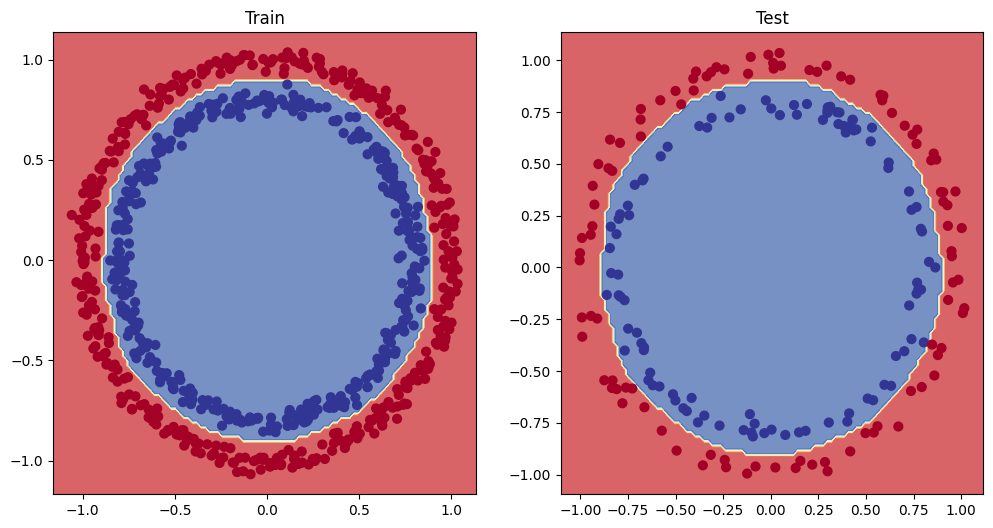

In [18]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

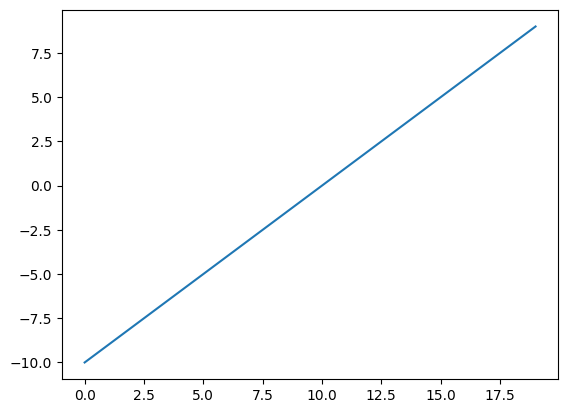

In [21]:
# Define non-linear activation function
A = torch.arange(-10, 10, 1, dtype = torch.float32)
plt.plot(A)

In [25]:
def customReLU(x):
    return torch.maximum(torch.tensor(0), x)

customReLU(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

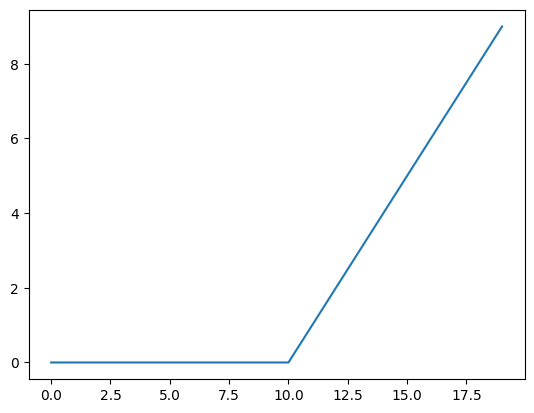

In [26]:
plt.plot(customReLU(A))

In [28]:
def customSigmoid(x):
    return 1 / (1+torch.exp(-x))

customSigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

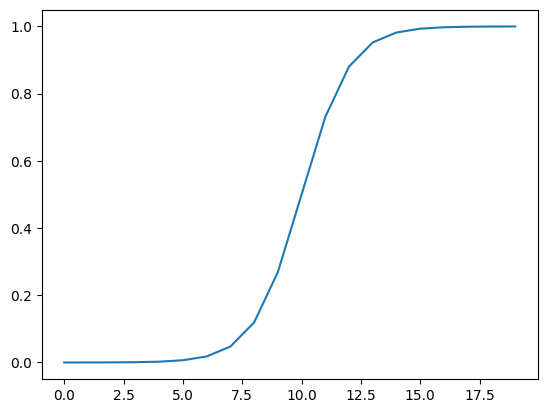

In [29]:
plt.plot(customSigmoid(A))